In [186]:
!pip install PyPortfolioOpt
!pip install yfinance
#importing libraries
from pandas_datareader import data as web
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from pypfopt import plotting
from matplotlib.pyplot import figure
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pandas_datareader import data as pdr
import yfinance as yfin
yfin.pdr_override()


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Importing dataset from yahoo Finance

In [187]:
#Tickers
assets = ['META','AAPL','NFLX','GOOG', 'AIG', 'QCOM']


#Initialize the dates:
StockStartDate = '2013-01-01'
StockEndDate = datetime.today().strftime('%Y-%m-%d')

In [188]:
#WEIGHTS FOR OUR stocks
#constraint, Sum = 1
weights = np.array([1/len(assets)]*len(assets))

In [189]:
#Create dataframe for "ADJ CLOSE" of the stocks
df = pd.DataFrame()

#Store the adj close

for stock in assets:
  df[stock] = pdr.get_data_yahoo(stock, start = StockStartDate, end = StockEndDate)['Adj Close']

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [190]:
df

,META,AAPL,NFLX,GOOG,AIG,QCOM
Date,,,,,,
2013-01-02,28.000000,16.862823,13.144286,18.013729,29.553608,48.689095
2013-01-03,27.770000,16.649982,13.798571,18.024191,29.310566,48.463520
2013-01-04,28.760000,16.186203,13.711429,18.380356,29.407784,47.749161
2013-01-07,29.420000,16.090984,14.171429,18.300158,29.108036,48.132648
2013-01-08,29.059999,16.134295,13.880000,18.264042,28.881207,48.057457
...,...,...,...,...,...,...
2022-12-12,114.709999,144.490005,315.179993,93.559998,63.190250,121.209999
2022-12-13,120.150002,145.470001,320.339996,95.849998,63.240002,123.489998
2022-12-14,121.589996,143.210007,317.829987,95.309998,62.660000,121.709999


In [191]:
mu = expected_returns.mean_historical_return(df)
S = risk_models.sample_cov(df)

<function matplotlib.pyplot.show(*args, **kw)>

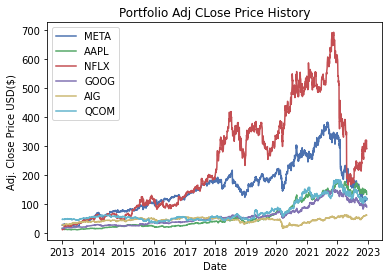

In [192]:
#visualize the path of the portfolio stocks
title = "Portfolio Adj CLose Price History"

# Get the stocks
my_stocks = df

#Create and plot the graph
for c in my_stocks.columns.values:
  plt.plot(my_stocks[c], label = c)


plt.title(title)
plt.xlabel("Date")
plt.ylabel("Adj. Close Price USD($)")
plt.legend(my_stocks.columns.values, loc = "upper left")
plt.show

In [193]:
#Show the daily simple return
returns = df.pct_change()
returns

,META,AAPL,NFLX,GOOG,AIG,QCOM
Date,,,,,,
2013-01-02,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-03,-0.008214,-0.012622,0.049777,0.000581,-0.008224,-0.004633
2013-01-04,0.035650,-0.027855,-0.006315,0.019760,0.003317,-0.014740
2013-01-07,0.022949,-0.005883,0.033549,-0.004363,-0.010193,0.008031
2013-01-08,-0.012237,0.002692,-0.020565,-0.001974,-0.007793,-0.001562
...,...,...,...,...,...,...
2022-12-12,-0.010267,0.016390,-0.015093,0.005265,0.015997,0.018144
2022-12-13,0.047424,0.006782,0.016372,0.024476,0.000787,0.018810
2022-12-14,0.011985,-0.015536,-0.007835,-0.005634,-0.009171,-0.014414


In [194]:
#Create and show the annualized covariance matrix
cov_matrix_annual = returns.cov() * 252

# Create and show the portoflio variance
port_variance = np.dot(weights.T, np.dot(cov_matrix_annual, weights))
port_variance

0.05983301513702393

In [195]:
#calculate the portfolio volatility
port_volatility = np.sqrt(port_variance)
port_volatility

0.24460788036574768

In [196]:
#Calculate the annual portoflio return
portfolioSimpleAnnualReturn = np.sum(returns.mean() *weights)*252
portfolioSimpleAnnualReturn

0.22759734309695015

In [197]:
from matplotlib.projections import process_projection_requirements
#Show the exp annual returns and variance

percent_var = str(round(port_variance , 2)*100)+ '%'
percent_vol = str(round(port_volatility, 2)*100)+'%'
percent_ret = str(round(portfolioSimpleAnnualReturn,2) * 100) +'%'



Optimiziation

In [198]:
#Portfolio Optimization

#Calc the exp returns and the anualized smaple covariance matrix of the asset returns
mu = expected_returns.mean_historical_return(df)
S = risk_models.sample_cov(df)

#Optimize for max sharpe ratio 
ef = EfficientFrontier(mu,S)

weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()
print(cleaned_weights)
ef.portfolio_performance(verbose = True)



OrderedDict([('META', 0.0), ('AAPL', 0.59721), ('NFLX', 0.36042), ('GOOG', 0.04237), ('AIG', 0.0), ('QCOM', 0.0)])
Expected annual return: 27.8%
Annual volatility: 28.8%
Sharpe Ratio: 0.90


(0.2775727839522436, 0.2875092596105982, 0.895876481686536)

Plot efficient frontier

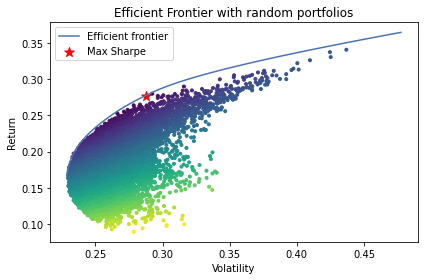

In [200]:
fig, ax = plt.subplots()
ef = EfficientFrontier(mu,S)
ef_max_sharpe = ef.deepcopy()
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=False)

# Find the tangency portfolio
ef_max_sharpe.max_sharpe()
ret_tangent, std_tangent, _ = ef_max_sharpe.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Max Sharpe")

# Generate random portfolios
n_samples = 10000
w = np.random.dirichlet(np.ones(ef.n_assets), n_samples)
rets = w.dot(ef.expected_returns)
stds = np.sqrt(np.diag(w @ ef.cov_matrix @ w.T))
sharpes = rets / stds
ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")

# Output
ax.set_title("Efficient Frontier with random portfolios")
ax.legend()
plt.tight_layout()
plt.savefig("ef_scatter.png", dpi=200)
plt.show()

In [201]:
print(df[:-1])

                  META        AAPL        NFLX       GOOG        AIG  \
Date                                                                   
2013-01-02   28.000000   16.862823   13.144286  18.013729  29.553608   
2013-01-03   27.770000   16.649982   13.798571  18.024191  29.310566   
2013-01-04   28.760000   16.186203   13.711429  18.380356  29.407784   
2013-01-07   29.420000   16.090984   14.171429  18.300158  29.108036   
2013-01-08   29.059999   16.134295   13.880000  18.264042  28.881207   
...                ...         ...         ...        ...        ...   
2022-12-09  115.900002  142.160004  320.010010  93.070000  62.195282   
2022-12-12  114.709999  144.490005  315.179993  93.559998  63.190250   
2022-12-13  120.150002  145.470001  320.339996  95.849998  63.240002   
2022-12-14  121.589996  143.210007  317.829987  95.309998  62.660000   
2022-12-15  116.150002  136.500000  290.410004  91.199997  62.209999   

                  QCOM  
Date                    
2013-01-02   

In [202]:
#Get the discrete allocation of each share per stock
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices
latest_prices = get_latest_prices(df)

weights = cleaned_weights
print(weights)
da = DiscreteAllocation(weights, latest_prices, total_portfolio_value= 10000)

allocation, leftover = da.lp_portfolio()
print("discrete Allocairton :", allocation)
print("Fund remaining :" , leftover)

OrderedDict([('META', 0.0), ('AAPL', 0.59721), ('NFLX', 0.36042), ('GOOG', 0.04237), ('AIG', 0.0), ('QCOM', 0.0)])
discrete Allocairton : {'AAPL': 44, 'NFLX': 12, 'GOOG': 5}
Fund remaining : 138.74033880510615


/usr/local/lib/python3.8/dist-packages/cvxpy/problems/problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


**ARIMA**

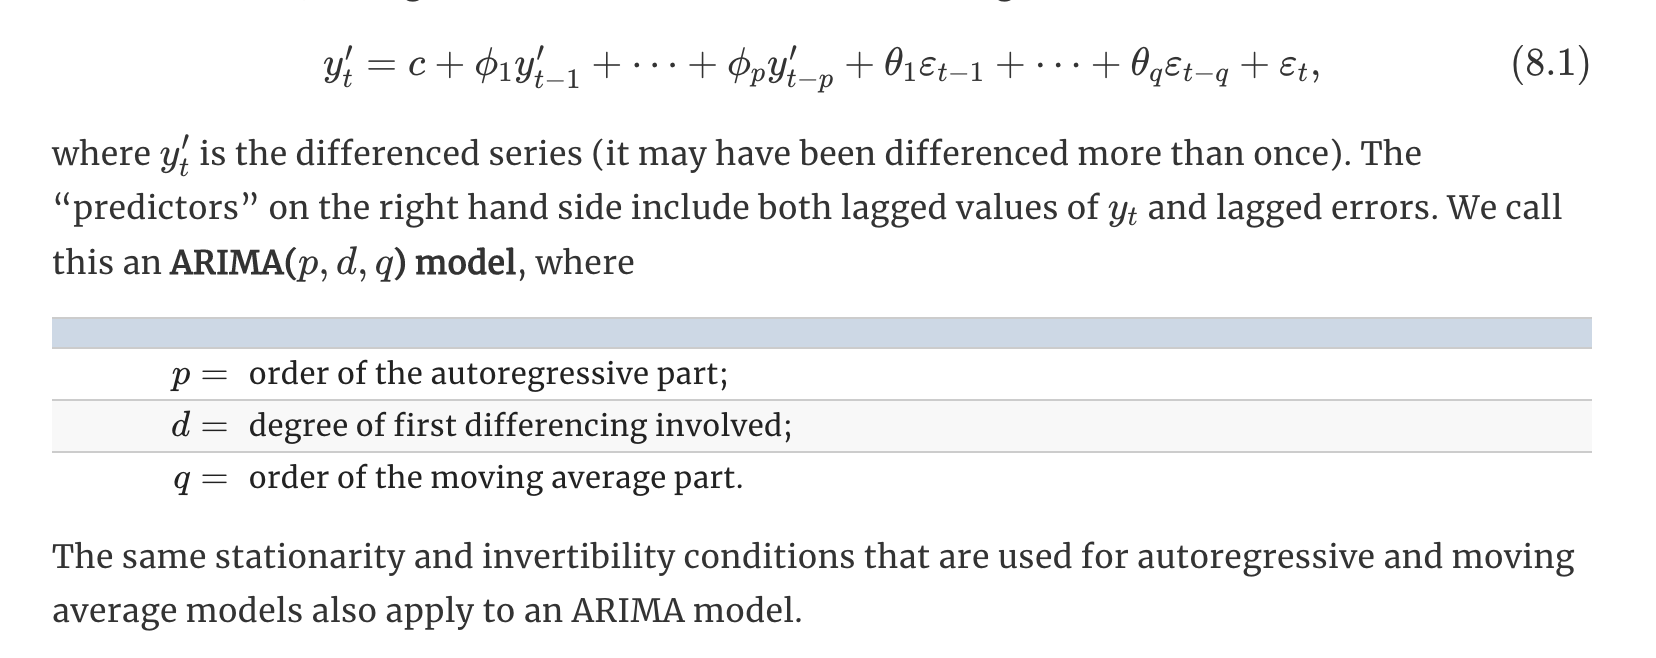

**Stationarity**

A stationary time series is one whose properties do not depend on the time at which the series is observed, or mean reverting.
In general, a stationary time series will have no predictable patterns in the long-term. Time plots will show the series to be roughly horizontal (although some cyclic behaviour is possible), with constant variance.

**Differencing**
A way to make a non-stationary time series stationary — compute the differences between consecutive observations. This is known as differencing.

Transformations such as logarithms can help to stabilise the variance of a time series. Differencing can help stabilise the mean of a time series by removing changes in the level of a time series, and therefore eliminating (or reducing) trend and seasonality.

**Unit root tests**
One way to determine more objectively whether differencing is required is to use a unit root test. These are statistical hypothesis tests of stationarity that are designed for determining whether differencing is required.

**Autoregressive models**
In an autoregression model, we forecast the variable of interest using a linear combination of past values of the variable. The term autoregression indicates that it is a regression of the variable against itself.

** Moving average models**
Rather than using past values of the forecast variable in a regression, a moving average model uses past forecast errors in a regression-like model

**Non-seasonal ARIMA models**

If we combine differencing with autoregression and a moving average model, we obtain a non-seasonal ARIMA model. 
https://otexts.com/fpp2/non-seasonal-arima.html

ACF and PACF plots
It is usually not possible to tell, simply from a time plot, what values of  
p and  q are appropriate for the data. However, it is sometimes possible to use the ACF plot, and the closely related PACF plot, to determine appropriate values for p and q.

If the data are from an ARIMA(p,d,0) or ARIMA(0,d,q) model, then the ACF and PACF plots can be helpful in determining the value of p or q. If p and q are both positive, then the plots do not help in finding suitable values of p and q.

https://otexts.com/fpp2/arima-estimation.html 

**Estimation and order selection**

Maximum likelihood estimation
Once the model order has been identified (i.e., the value of p,d,q) When R estimates the ARIMA model, it uses maximum likelihood estimation (MLE). This technique finds the values of the parameters which maximise the probability of obtaining the data that we have observed. For ARIMA models, MLE is similar to the least squares estimates that would be obtained by minimising



 **ADF test
We'lll use the ADF test to check if the price is stationary
The null hypothesis of the ADF test is that the time series is non -staionary. So if the p value is less than the significance level (0.05) then we can reject the null hypothesis and infer that the time series is stationary.**


**So in our case, if the p valye > .05, we'll need to find the order of differencing.**


In [203]:
df 

,META,AAPL,NFLX,GOOG,AIG,QCOM
Date,,,,,,
2013-01-02,28.000000,16.862823,13.144286,18.013729,29.553608,48.689095
2013-01-03,27.770000,16.649982,13.798571,18.024191,29.310566,48.463520
2013-01-04,28.760000,16.186203,13.711429,18.380356,29.407784,47.749161
2013-01-07,29.420000,16.090984,14.171429,18.300158,29.108036,48.132648
2013-01-08,29.059999,16.134295,13.880000,18.264042,28.881207,48.057457
...,...,...,...,...,...,...
2022-12-12,114.709999,144.490005,315.179993,93.559998,63.190250,121.209999
2022-12-13,120.150002,145.470001,320.339996,95.849998,63.240002,123.489998
2022-12-14,121.589996,143.210007,317.829987,95.309998,62.660000,121.709999


In [204]:
from pandas.core.ops.methods import add_flex_arithmetic_methods
from statsmodels.tsa.stattools import adfuller
ADFTest = []
i = 0
for stock in assets:
  temp = df[stock]
  #result[i] = adfuller(df[stock])
  ADFTest.append(adfuller(df[stock]))
  i = i+1

for i in range(len(assets)):
  print(f'ADF statistics of {assets[i]}:{ADFTest[i][0]}')
  print(f'p value of {assets[i]} : {ADFTest[i][1]}')

ADF statistics of META:-1.6667656365936965
p value of META : 0.4483119992941476
ADF statistics of AAPL:-0.31146109591502735
p value of AAPL : 0.923865339774846
ADF statistics of NFLX:-1.4335505601650373
p value of NFLX : 0.5660901117309964
ADF statistics of GOOG:-0.8751898661734564
p value of GOOG : 0.7960329276601287
ADF statistics of AIG:-2.335961094367706
p value of AIG : 0.1606319039821173
ADF statistics of QCOM:-1.2230002344631652
p value of QCOM : 0.6636241699666046


ACF plot
It tells us how many terms are required to remove autocorrelation.

In [205]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller

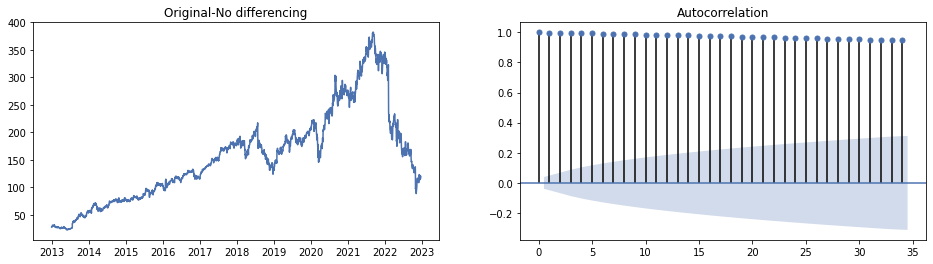

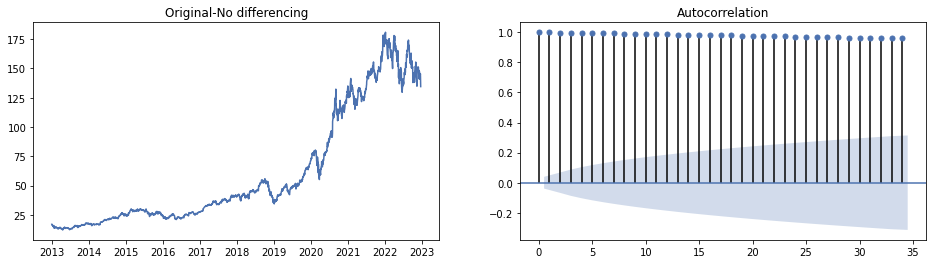

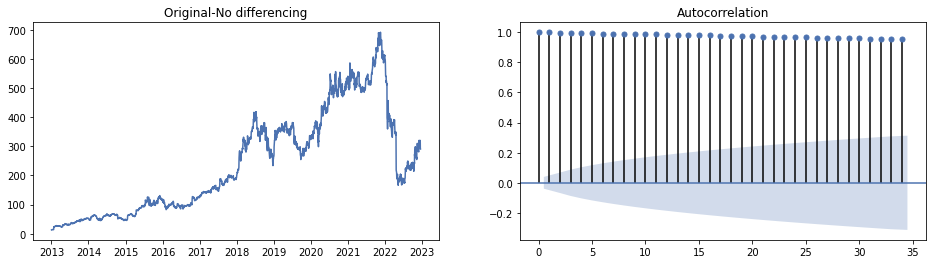

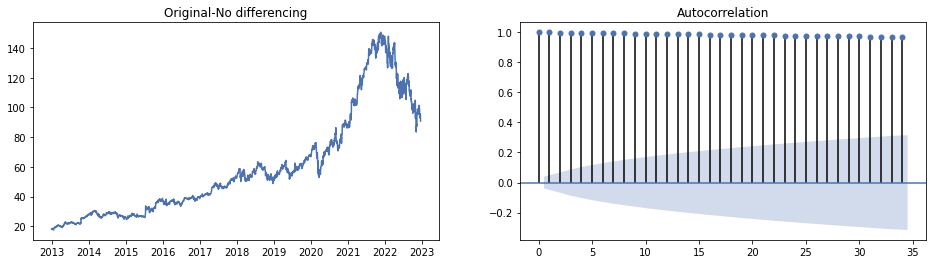

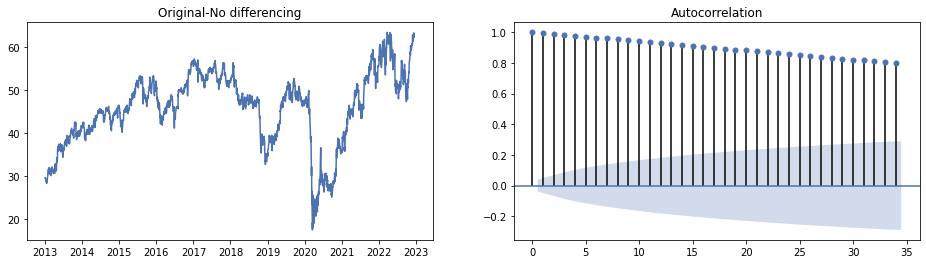

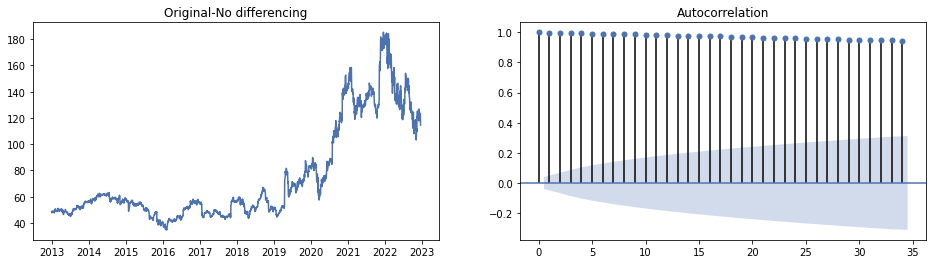

In [206]:
for c in df.columns.values:
  fig, (ax1, ax2) = plt.subplots(1,2,figsize =(16,4))

  ax1.plot(df[c])
  ax1.set_title("Original-No differencing")
  plot_acf(df[c],ax = ax2);

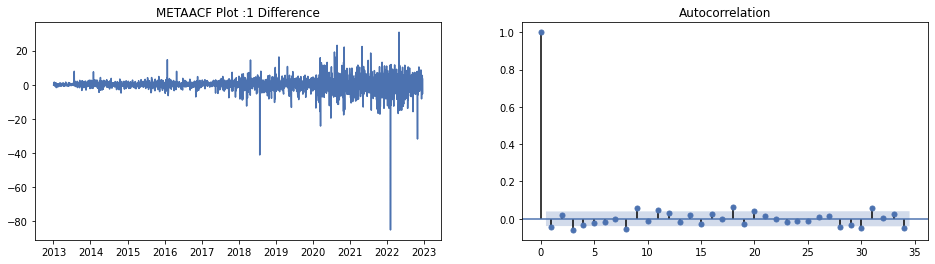

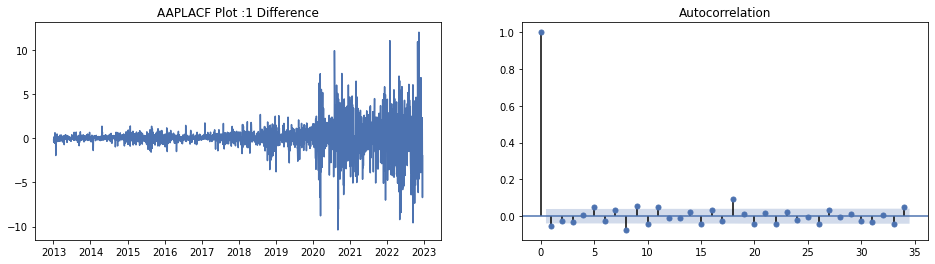

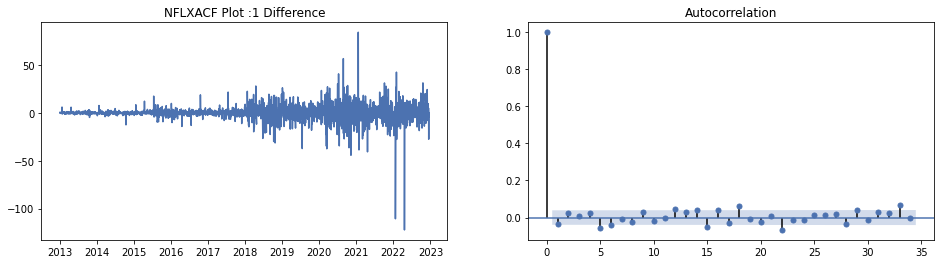

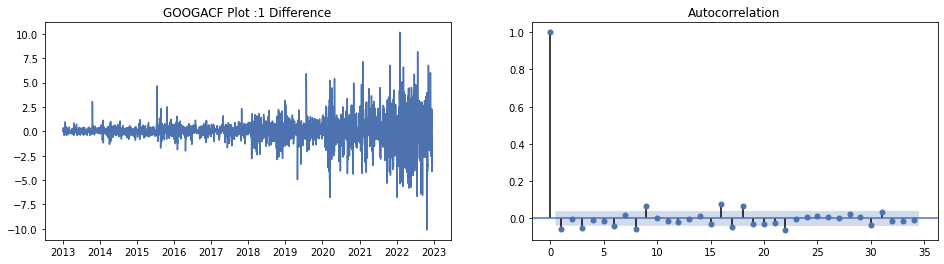

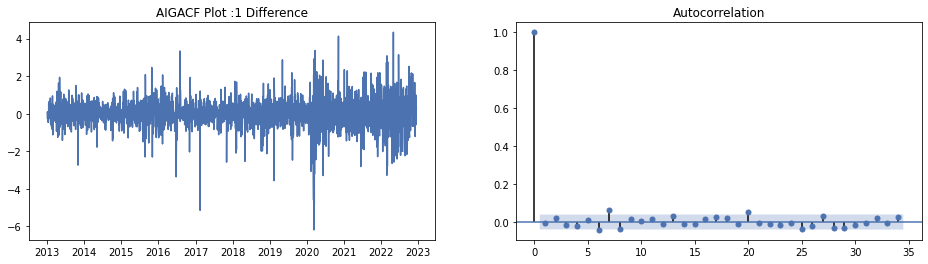

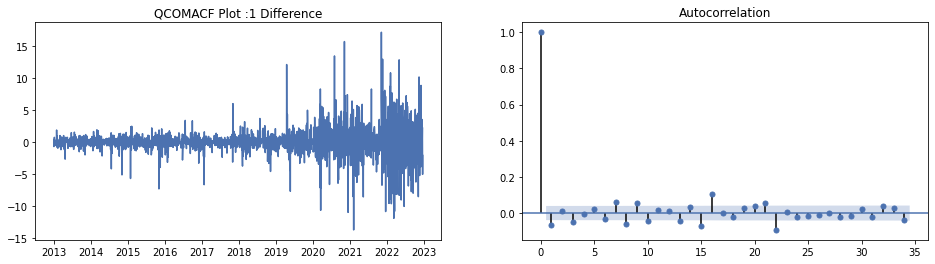

In [207]:
for c in df.columns.values:
  diff = df[c].diff().dropna()
  fig, (ax1, ax2) = plt.subplots(1,2,figsize =(16,4))

  ax1.plot(diff)
  ax1.set_title(f'{c}ACF Plot :1 Difference')
  plot_acf(diff,ax = ax2);


Or we can use the pmdarima package to get the number of differencing.

In [208]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**P**

p is the orer of the AR term. It refers to the number of lags to be used as predictors
We can find it by inspecting the Partial Autocorrelation plot (PACF).
The partial autocorrelation represents the correlation between the series and its lags.

Partial autocorrelation plot shows the corr between series and its lags

In [209]:
from statsmodels.graphics.tsaplots import plot_pacf

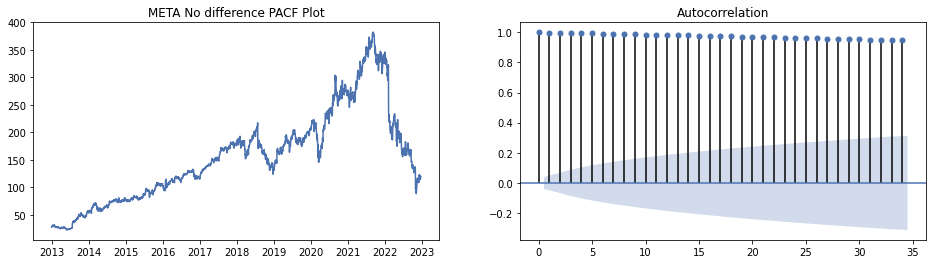

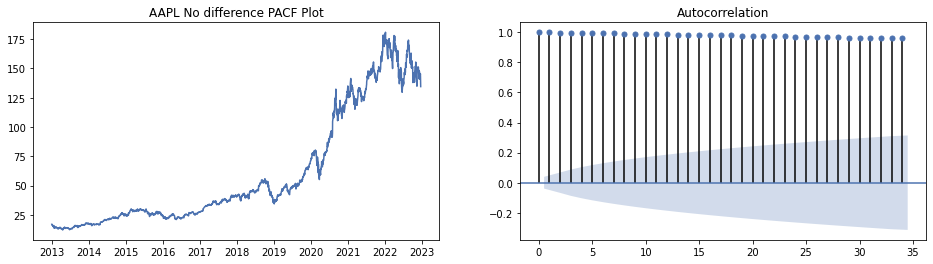

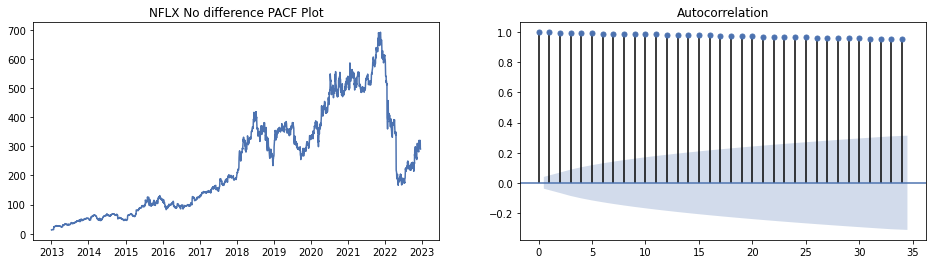

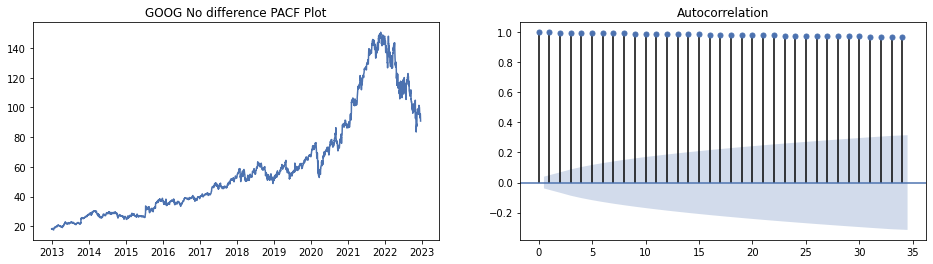

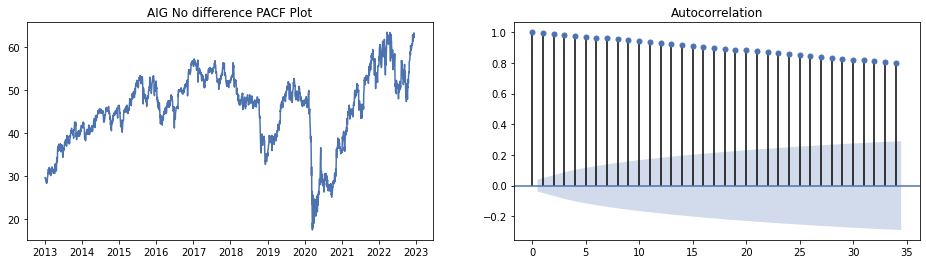

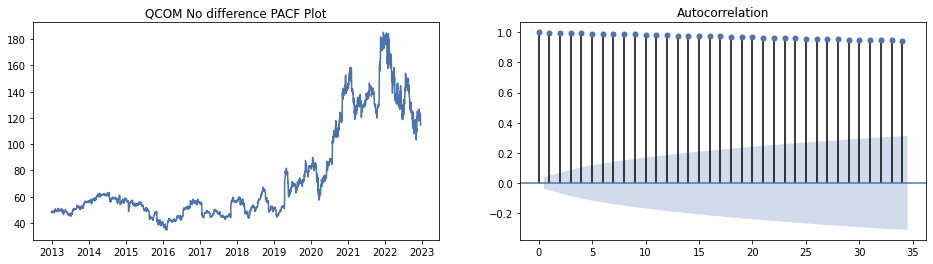

In [210]:
for c in df.columns.values:
  fig, (ax1, ax2) = plt.subplots(1,2,figsize =(16,4))

  ax1.plot(df[c])
  ax1.set_title(f'{c} No difference PACF Plot')
  plot_acf(df[c],ax = ax2);

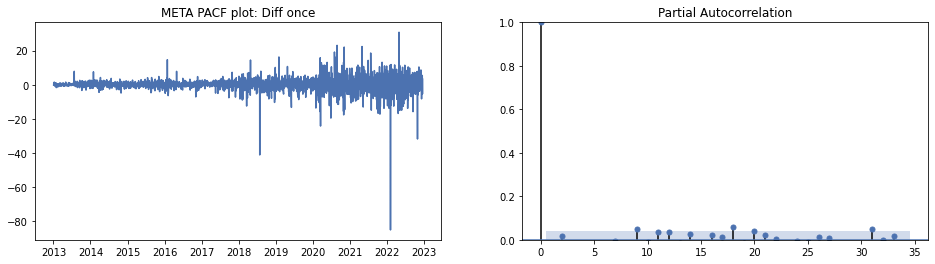

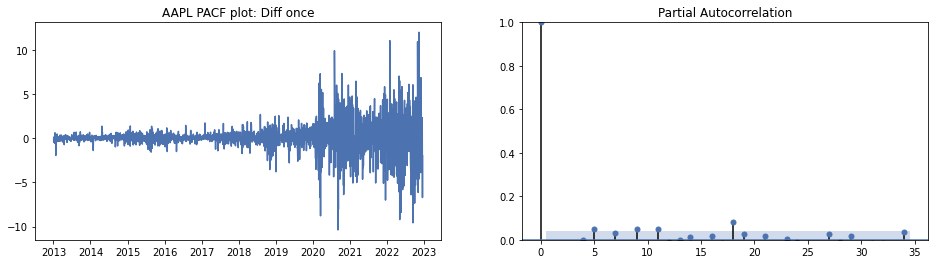

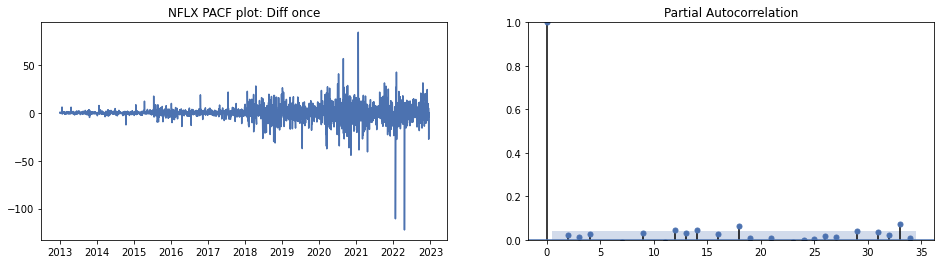

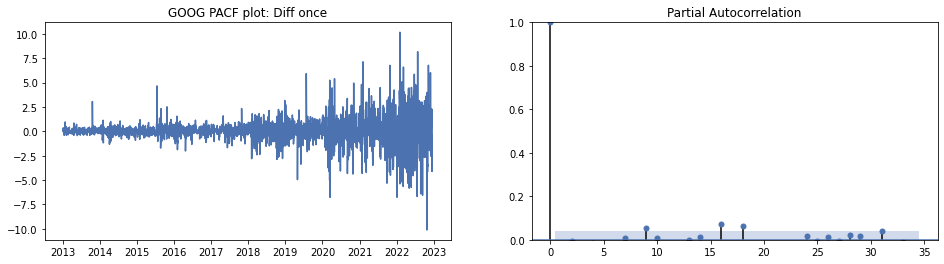

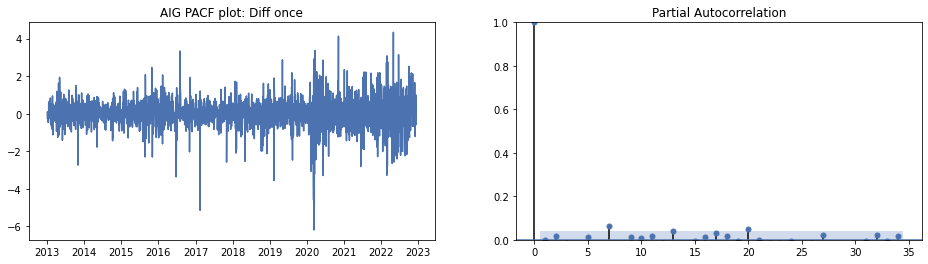

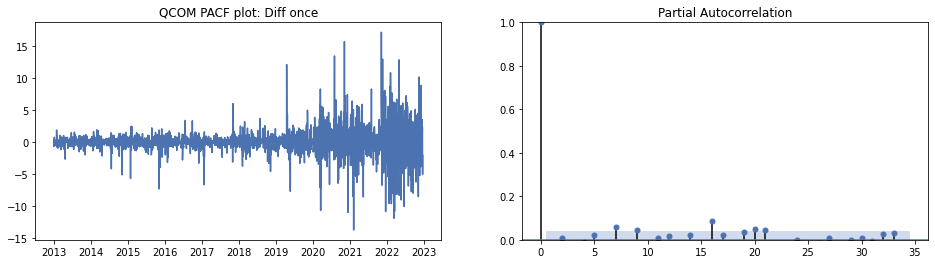

In [211]:
for c in df.columns.values:
  diff = df[c].diff().dropna()

  fig, (ax1, ax2) = plt.subplots(1,2,figsize =(16,4))
  ax1.plot(diff)
  ax1.set_title(f'{c} PACF plot: Diff once')
  ax2.set_ylim(0,1)
  plot_pacf(diff, ax = ax2);

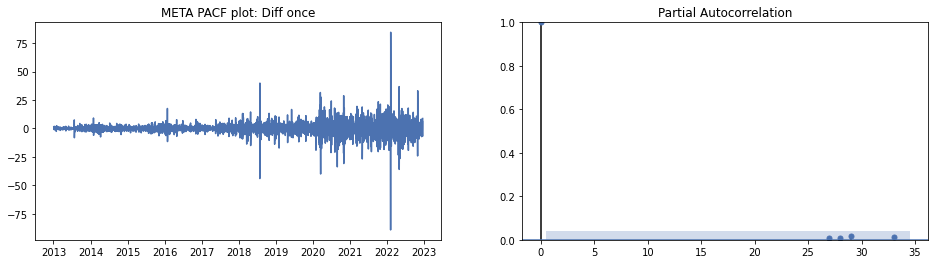

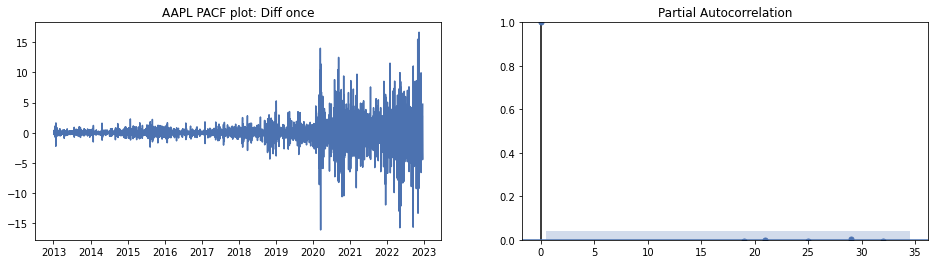

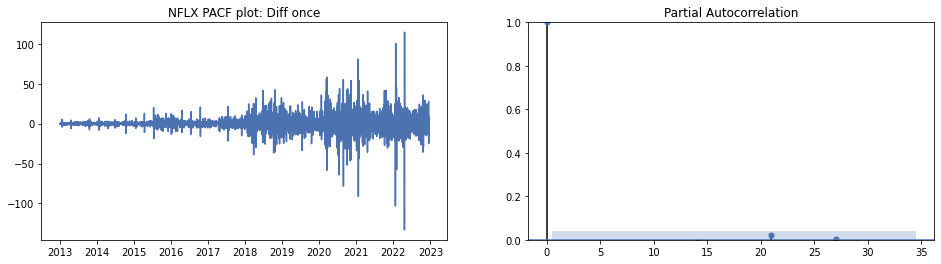

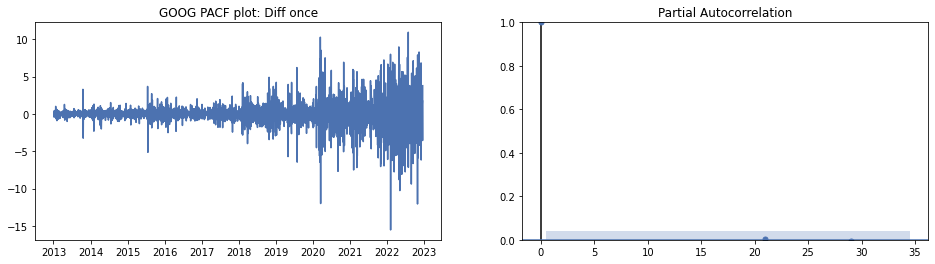

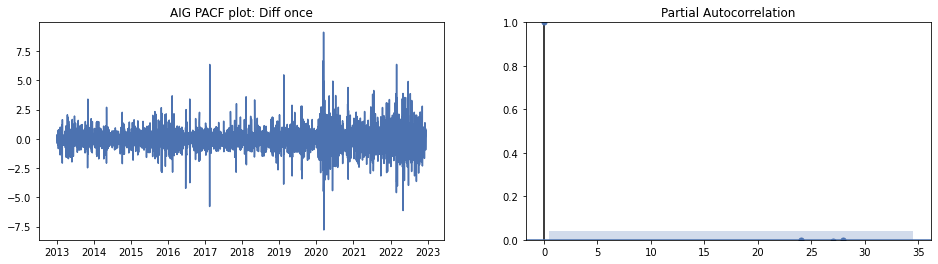

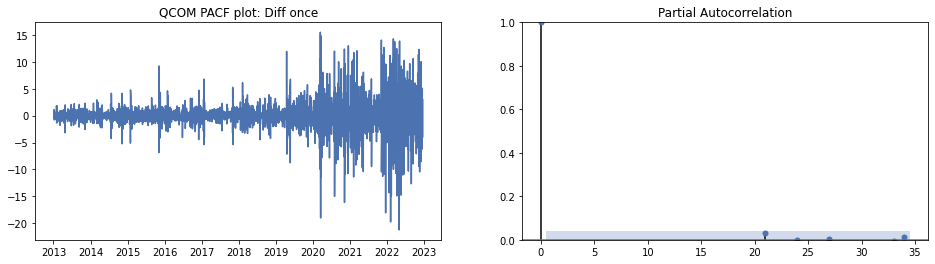

In [212]:
for c in df.columns.values:
  diff = df[c].diff().diff().dropna()

  fig, (ax1, ax2) = plt.subplots(1,2,figsize =(16,4))
  ax1.plot(diff)
  ax1.set_title(f'{c} PACF plot: Diff once')
  ax2.set_ylim(0,1)
  plot_pacf(diff, ax = ax2);

In here lag number 16 in the plot is above the significance line. We are using 16.


**q**

q is the order of the MA term. It refers to the number of lagged forecast errors that should go into the ARIMA model.
We can look at the ACF plot for the number of MA terms.


ACF PLOT


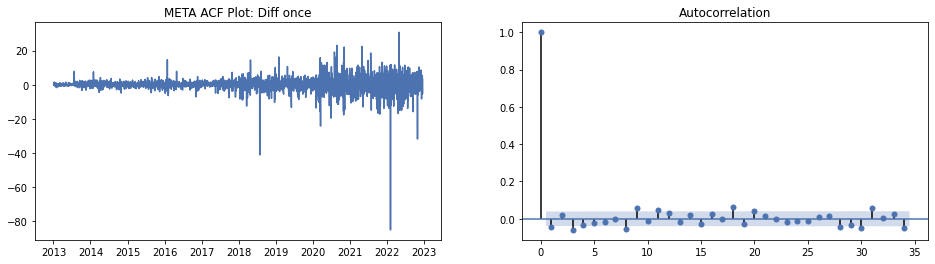

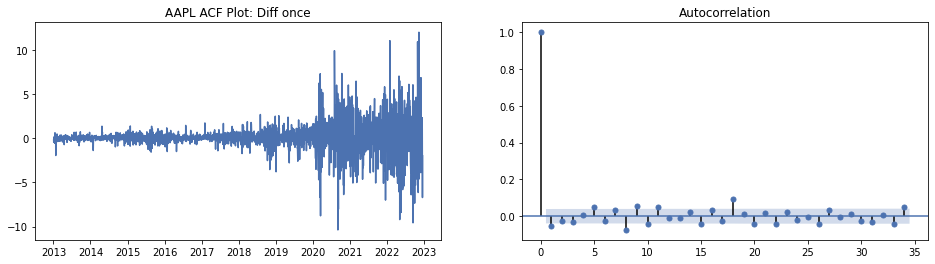

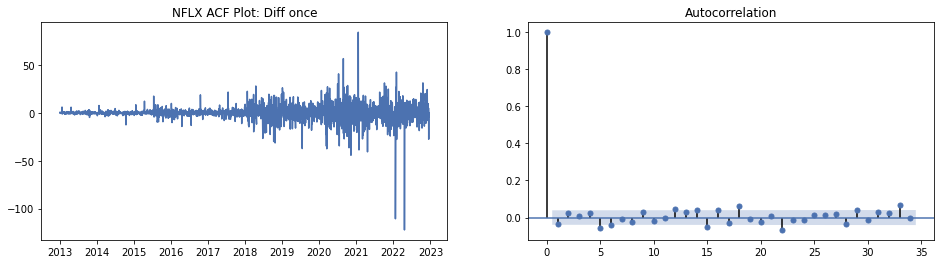

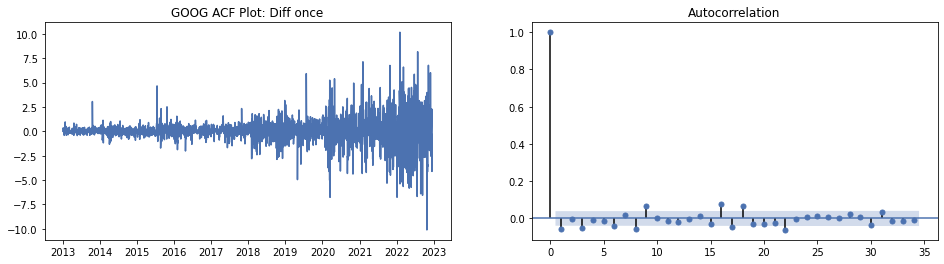

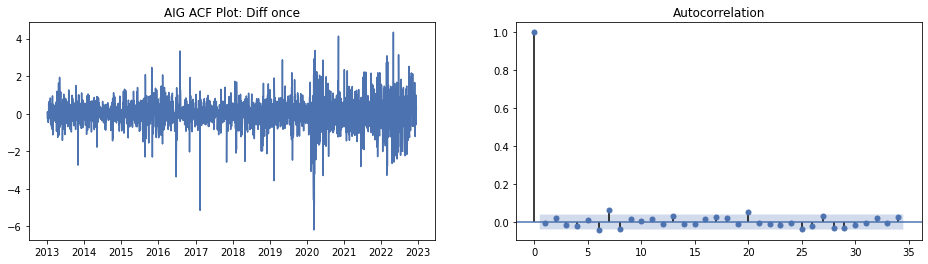

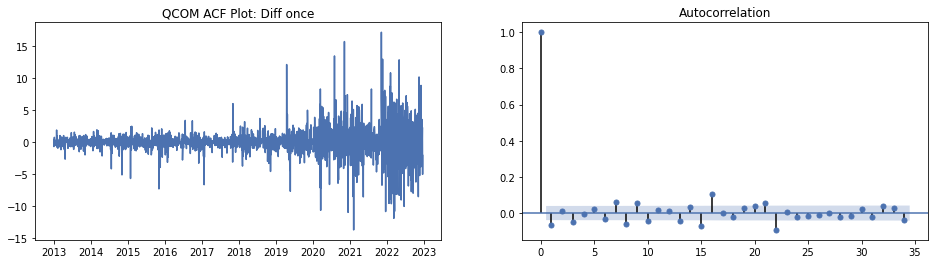

In [213]:
print("ACF PLOT")
for c in df.columns.values:

  diff = df[c].diff().dropna()
  fig, (ax1, ax2) = plt.subplots(1,2,figsize =(16,4))

  ax1.plot(diff)
  ax1.set_title(f'{c} ACF Plot: Diff once')
  plot_acf(diff,ax = ax2);

In here lag 3 and 8 is out of the significance line. So q = 3

Therefore q = 3, p = 16. Try both for now.

**AAPL**

**TEST AND TRAIN**

**WORKING MODEL FROM TEST TRAIN MODULE**

Apple

In [214]:
n = int(len(df)*0.8)
train = df.AAPL[:n]
test = df.AAPL[n:]

In [215]:
from statsmodels.tsa.arima_model import ARIMA
#ARIMA Model implementation 
#ARIMA(p,d,q) 
model = ARIMA(train, order = (5,1,1))
result = model.fit(disp=0)

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  in

In [216]:
print(result.summary())

                             ARIMA Model Results                              
Dep. Variable:                 D.AAPL   No. Observations:                 2006
Model:                 ARIMA(5, 1, 1)   Log Likelihood               -2850.631
Method:                       css-mle   S.D. of innovations              1.002
Date:                Sat, 17 Dec 2022   AIC                           5717.263
Time:                        00:53:07   BIC                           5762.094
Sample:                             1   HQIC                          5733.721
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0542      0.021      2.603      0.009       0.013       0.095
ar.L1.D.AAPL    -0.9338      0.066    -14.118      0.000      -1.063      -0.804
ar.L2.D.AAPL    -0.0659      0.032     -2.08

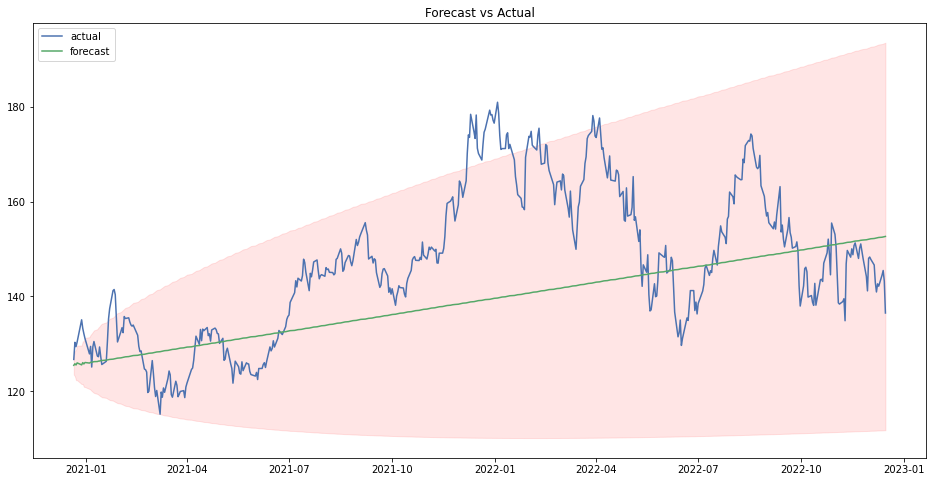

In [217]:
step = 501 #Len of the test
fc , se , conf = result.forecast(step)
fc = pd.Series(fc, index = test[ : step].index)
lower = pd.Series(conf[: ,0], index = test[: step].index)
upper = pd.Series(conf[: ,1], index = test[: step].index)
plt.figure(figsize = (16,8))
plt.plot(test[:step], label = "actual")
plt.plot(fc,label = "forecast")
plt.fill_between(lower.index,lower,upper,color="r",alpha = 0.1)
plt.title("Forecast vs Actual")
plt.legend(loc = "upper left")

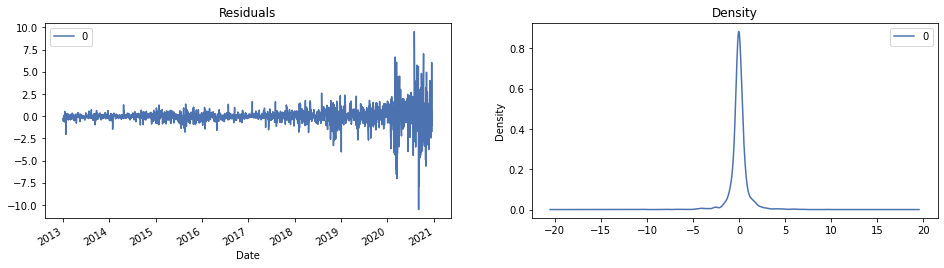

In [218]:
residuals = pd.DataFrame(result.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title='Residuals', ax=ax[0], figsize = (16,4))
residuals.plot(title='Density', kind='kde', ax=ax[1])
plt.show();

<Figure size 1152x11520 with 0 Axes>

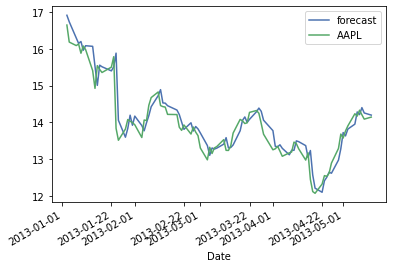

In [219]:
#actual vs fitted 
#figure(figsize=(20, 30), dpi=400)
plt.figure(figsize=(16,160))
result.plot_predict(
    start = 1,
    end = 90,
    dynamic= False
);

<Figure size 1152x11520 with 0 Axes>

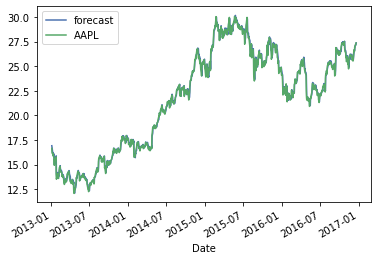

In [220]:
#actual vs fitted 
#figure(figsize=(20, 30), dpi=400)
plt.figure(figsize=(16,160))
result.plot_predict(
    start = 1,
    end = 1000,
    dynamic= False
);

In [221]:
step = 1000
fc , se , conf = result.forecast(step)

In [222]:
#futAapl = pd.DataFrame(fc)
#futAapl
begin_date = '2022-12-13'
Apple = pd.DataFrame({'Date':pd.date_range(begin_date, periods=step),
                      "AAPL": fc
                   }).set_index('Date')
'''
temp = df.append(Apple)

temp
'''

'\ntemp = df.append(Apple)\n\ntemp\n'

META

In [223]:
n = int(len(df)*0.8)
train = df.META[:n]
test = df.META[n:]

In [224]:

#ARIMA Model implementation 
#ARIMA(p,d,q) 
model_META = ARIMA(train, order = (16,1,3))
result_META = model_META.fit(disp=0)

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  in

In [225]:
print(result_META.summary())

                             ARIMA Model Results                              
Dep. Variable:                 D.META   No. Observations:                 2006
Model:                ARIMA(16, 1, 3)   Log Likelihood               -5096.901
Method:                       css-mle   S.D. of innovations              3.070
Date:                Sat, 17 Dec 2022   AIC                          10235.803
Time:                        00:54:44   BIC                          10353.485
Sample:                             1   HQIC                         10279.007
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.1239      0.061      2.017      0.044       0.004       0.244
ar.L1.D.META      0.7528      0.123      6.115      0.000       0.512       0.994
ar.L2.D.META      0.3065      0.167     

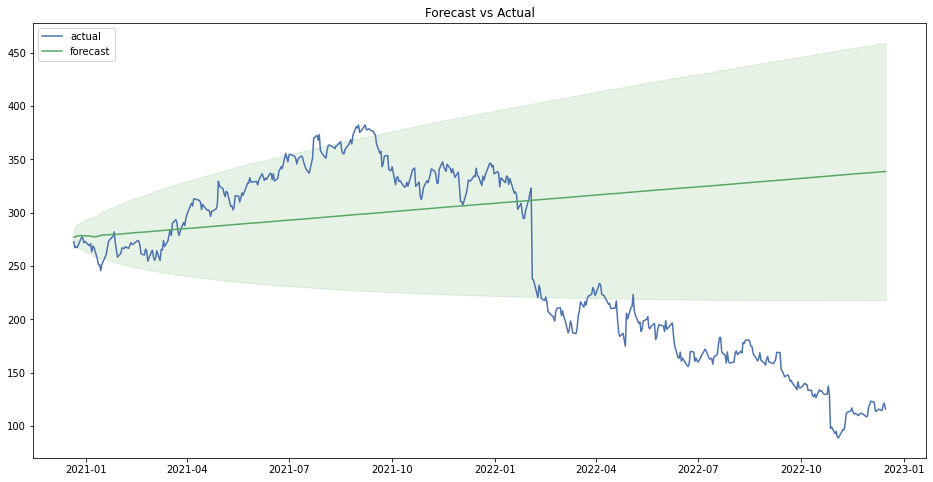

In [226]:
step = 501 #Len of the test
fc , se , conf = result_META.forecast(step)
fc = pd.Series(fc, index = test[ : step].index)
lower = pd.Series(conf[: ,0], index = test[: step].index)
upper = pd.Series(conf[: ,1], index = test[: step].index)
plt.figure(figsize = (16,8))
plt.plot(test[:step], label = "actual")
plt.plot(fc,label = "forecast")
plt.fill_between(lower.index,lower,upper,color="g",alpha = 0.1)
plt.title("Forecast vs Actual")
plt.legend(loc = "upper left")

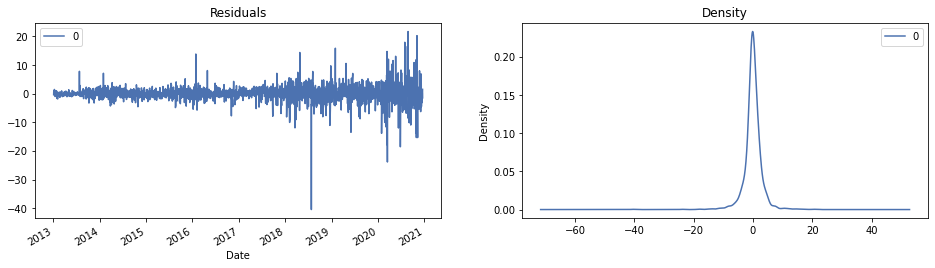

In [227]:
residuals = pd.DataFrame(result_META.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title='Residuals', ax=ax[0], figsize = (16,4))
residuals.plot(title='Density', kind='kde', ax=ax[1])
plt.show();

<Figure size 1152x11520 with 0 Axes>

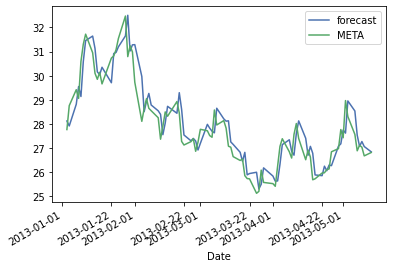

In [228]:
#actual vs fitted 
#figure(figsize=(20, 30), dpi=400)
plt.figure(figsize=(16,160))
result_META.plot_predict(
    start = 1,
    end = 90,
    dynamic= False
);

<Figure size 1152x11520 with 0 Axes>

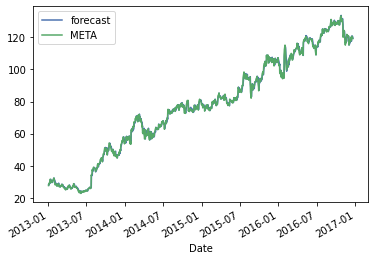

In [229]:
#actual vs fitted 
#figure(figsize=(20, 30), dpi=400)
plt.figure(figsize=(16,160))
result_META.plot_predict(
    start = 1,
    end = 1000,
    dynamic= False
);

In [230]:
step = 1000
fc , se , conf = result_META.forecast(step)

In [231]:
#futAapl = pd.DataFrame(fc)
#futAapl
begin_date = '2022-12-13'
META = pd.DataFrame({'Date':pd.date_range(begin_date, periods=step),
                      "META": fc
                   }).set_index('Date')


Google


In [232]:
n = int(len(df)*0.8)
train = df.GOOG[:n]
test = df.GOOG[n:]

In [233]:
from statsmodels.tsa.arima_model import ARIMA
#ARIMA Model implementation 
#ARIMA(p,d,q) 
model = ARIMA(train, order = (16,1,1))
result_GOOG = model.fit(disp=0)

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  in

In [234]:
print(result_GOOG.summary())

                             ARIMA Model Results                              
Dep. Variable:                 D.GOOG   No. Observations:                 2006
Model:                ARIMA(16, 1, 1)   Log Likelihood               -2376.877
Method:                       css-mle   S.D. of innovations              0.791
Date:                Sat, 17 Dec 2022   AIC                           4791.755
Time:                        00:56:19   BIC                           4898.229
Sample:                             1   HQIC                          4830.844
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0343      0.017      2.050      0.040       0.001       0.067
ar.L1.D.GOOG      0.2617      0.264      0.992      0.321      -0.255       0.778
ar.L2.D.GOOG      0.0181      0.031     

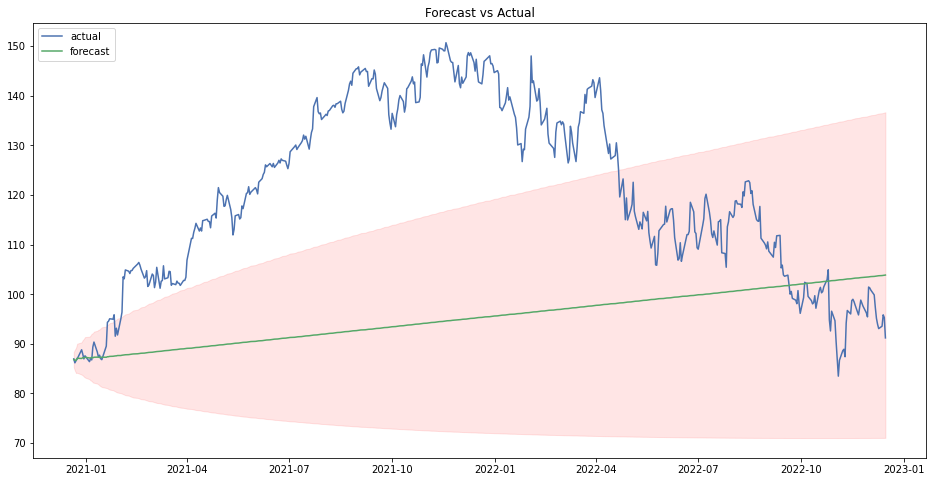

In [235]:
step = 501 #Len of the test
fc , se , conf = result_GOOG.forecast(step)
fc = pd.Series(fc, index = test[ : step].index)
lower = pd.Series(conf[: ,0], index = test[: step].index)
upper = pd.Series(conf[: ,1], index = test[: step].index)
plt.figure(figsize = (16,8))
plt.plot(test[:step], label = "actual")
plt.plot(fc,label = "forecast")
plt.fill_between(lower.index,lower,upper,color="r",alpha = 0.1)
plt.title("Forecast vs Actual")
plt.legend(loc = "upper left")

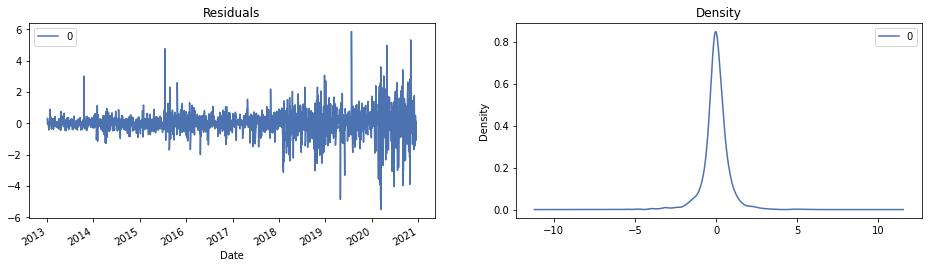

In [236]:
residuals = pd.DataFrame(result_GOOG.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title='Residuals', ax=ax[0], figsize = (16,4))
residuals.plot(title='Density', kind='kde', ax=ax[1])
plt.show();

<Figure size 1152x11520 with 0 Axes>

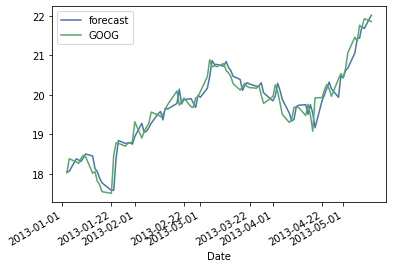

In [237]:
#actual vs fitted 
#figure(figsize=(20, 30), dpi=400)
plt.figure(figsize=(16,160))
result_GOOG.plot_predict(
    start = 1,
    end = 90,
    dynamic= False
);

<Figure size 1152x11520 with 0 Axes>

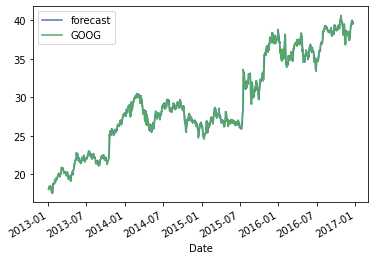

In [238]:
#actual vs fitted 
#figure(figsize=(20, 30), dpi=400)
plt.figure(figsize=(16,160))
result_GOOG.plot_predict(
    start = 1,
    end = 1000,
    dynamic= False
);

In [239]:
step = 1000
fc , se , conf = result_GOOG.forecast(step)

In [240]:
#futAapl = pd.DataFrame(fc)
#futAapl
begin_date = '2022-12-13'
GOOG = pd.DataFrame({'Date':pd.date_range(begin_date, periods=step),
                      "GOOG": fc
                   }).set_index('Date')


AIG

In [241]:
n = int(len(df)*0.8)
train = df.AIG[:n]
test = df.AIG[n:]

In [242]:
from statsmodels.tsa.arima_model import ARIMA
#ARIMA Model implementation 
#ARIMA(p,d,q) 
model_AIG = ARIMA(train, order = (6,1,6))
result_AIG = model_AIG.fit(disp=0)

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  in

In [243]:
print(result_AIG.summary())

                             ARIMA Model Results                              
Dep. Variable:                  D.AIG   No. Observations:                 2006
Model:                 ARIMA(6, 1, 6)   Log Likelihood               -2144.740
Method:                       css-mle   S.D. of innovations              0.704
Date:                Sat, 17 Dec 2022   AIC                           4317.480
Time:                        00:57:37   BIC                           4395.935
Sample:                             1   HQIC                          4346.283
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0030      0.018      0.172      0.864      -0.031       0.037
ar.L1.D.AIG    -1.2036      0.185     -6.518      0.000      -1.566      -0.842
ar.L2.D.AIG    -0.8626      0.308     -2.801    

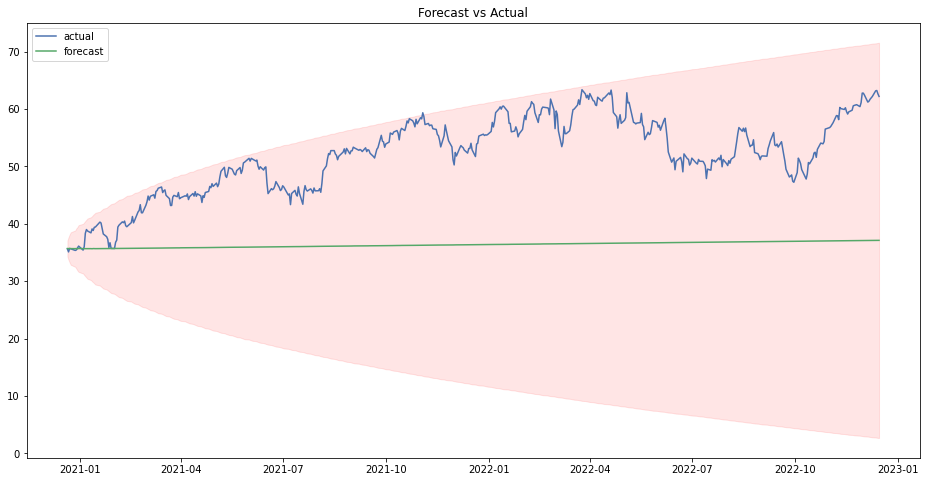

In [244]:
step = 501 #Len of the test
fc , se , conf = result_AIG.forecast(step)
fc = pd.Series(fc, index = test[ : step].index)
lower = pd.Series(conf[: ,0], index = test[: step].index)
upper = pd.Series(conf[: ,1], index = test[: step].index)
plt.figure(figsize = (16,8))
plt.plot(test[:step], label = "actual")
plt.plot(fc,label = "forecast")
plt.fill_between(lower.index,lower,upper,color="r",alpha = 0.1)
plt.title("Forecast vs Actual")
plt.legend(loc = "upper left")

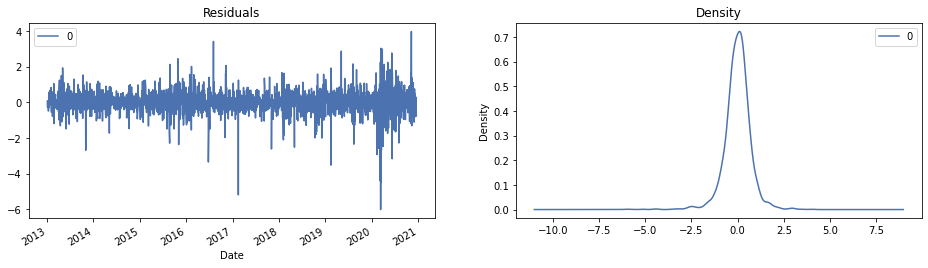

In [245]:
residuals = pd.DataFrame(result_AIG.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title='Residuals', ax=ax[0], figsize = (16,4))
residuals.plot(title='Density', kind='kde', ax=ax[1])
plt.show();

<Figure size 1152x11520 with 0 Axes>

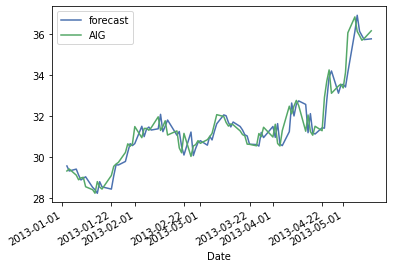

In [246]:
#actual vs fitted 
#figure(figsize=(20, 30), dpi=400)
plt.figure(figsize=(16,160))
result_AIG.plot_predict(
    start = 1,
    end = 90,
    dynamic= False
);

<Figure size 1152x11520 with 0 Axes>

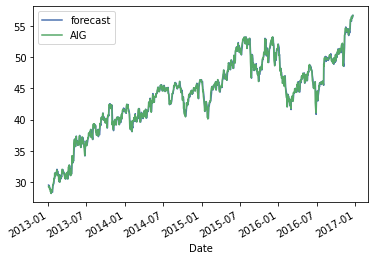

In [247]:
#actual vs fitted 
#figure(figsize=(20, 30), dpi=400)
plt.figure(figsize=(16,160))
result_AIG.plot_predict(
    start = 1,
    end = 1000,
    dynamic= False
);

In [248]:
step = 1000
fc , se , conf = result_AIG.forecast(step)

In [249]:
#futAapl = pd.DataFrame(fc)
#futAapl
begin_date = '2022-12-13'
AIG = pd.DataFrame({'Date':pd.date_range(begin_date, periods=step),
                      "AIG": fc
                   }).set_index('Date')
'''
temp = df.append(Apple)

temp
'''

'\ntemp = df.append(Apple)\n\ntemp\n'

QCOM

In [250]:
n = int(len(df)*0.8)
train = df.QCOM[:n]
test = df.QCOM[n:]

In [251]:
from statsmodels.tsa.arima_model import ARIMA
#ARIMA Model implementation 
#ARIMA(p,d,q) 
model_QCOM = ARIMA(train, order = (7,1,1))
result_QCOM = model_QCOM.fit(disp=0)

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  in

In [252]:
print(result_QCOM.summary())

                             ARIMA Model Results                              
Dep. Variable:                 D.QCOM   No. Observations:                 2006
Model:                 ARIMA(7, 1, 1)   Log Likelihood               -3455.454
Method:                       css-mle   S.D. of innovations              1.355
Date:                Sat, 17 Dec 2022   AIC                           6930.907
Time:                        00:57:46   BIC                           6986.946
Sample:                             1   HQIC                          6951.480
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0463      0.030      1.528      0.126      -0.013       0.106
ar.L1.D.QCOM    -0.6027      0.081     -7.422      0.000      -0.762      -0.444
ar.L2.D.QCOM     0.0304      0.027      1.12

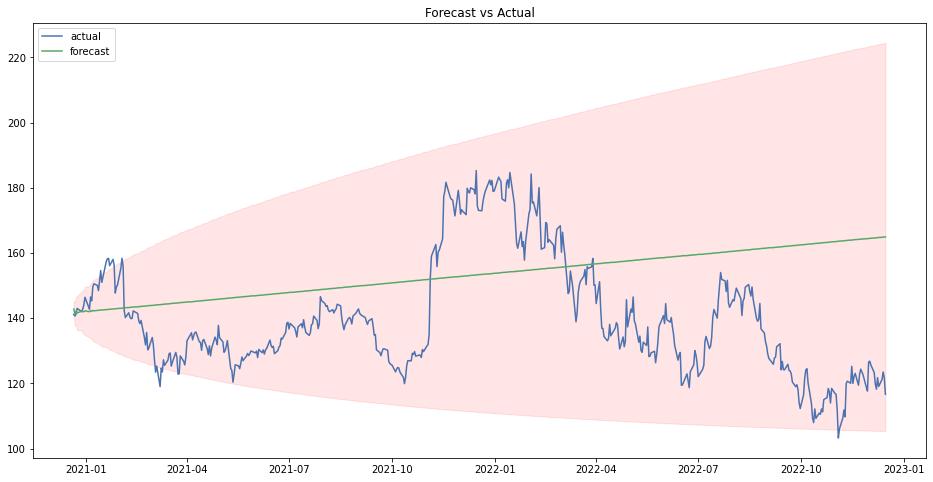

In [253]:
step = 501 #Len of the test
fc , se , conf = result_QCOM.forecast(step)
fc = pd.Series(fc, index = test[ : step].index)
lower = pd.Series(conf[: ,0], index = test[: step].index)
upper = pd.Series(conf[: ,1], index = test[: step].index)
plt.figure(figsize = (16,8))
plt.plot(test[:step], label = "actual")
plt.plot(fc,label = "forecast")
plt.fill_between(lower.index,lower,upper,color="r",alpha = 0.1)
plt.title("Forecast vs Actual")
plt.legend(loc = "upper left")

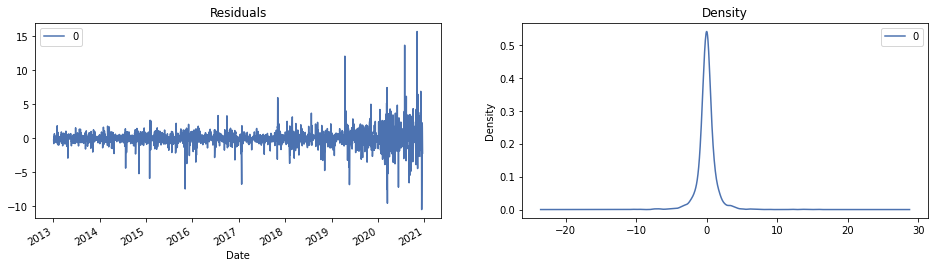

In [254]:
residuals = pd.DataFrame(result_QCOM.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title='Residuals', ax=ax[0], figsize = (16,4))
residuals.plot(title='Density', kind='kde', ax=ax[1])
plt.show();

<Figure size 1152x11520 with 0 Axes>

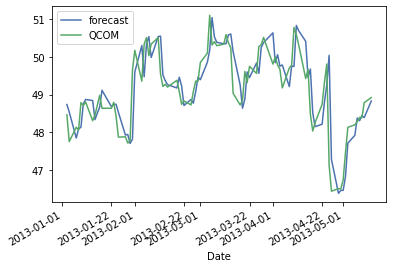

In [255]:
#actual vs fitted 
#figure(figsize=(20, 30), dpi=400)
plt.figure(figsize=(16,160))
result_QCOM.plot_predict(
    start = 1,
    end = 90,
    dynamic= False
);

<Figure size 1152x11520 with 0 Axes>

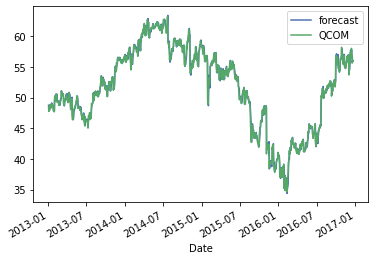

In [256]:
#actual vs fitted 
#figure(figsize=(20, 30), dpi=400)
plt.figure(figsize=(16,160))
result_QCOM.plot_predict(
    start = 1,
    end = 1000,
    dynamic= False
);

In [257]:
step = 1000
fc , se , conf = result_QCOM.forecast(step)

In [258]:
#futAapl = pd.DataFrame(fc)
#futAapl
begin_date = '2022-12-13'
QCOM = pd.DataFrame({'Date':pd.date_range(begin_date, periods=step),
                      "QCOM": fc
                   }).set_index('Date')
'''
temp = df.append(Apple)

temp
'''

'\ntemp = df.append(Apple)\n\ntemp\n'

Netflix

In [259]:
n = int(len(df)*0.8)
train = df.NFLX[:n]
test = df.NFLX[n:]

In [260]:
from statsmodels.tsa.arima_model import ARIMA
#ARIMA Model implementation 
#ARIMA(p,d,q) 
model_NFLX = ARIMA(train, order = (18,1,15))
result_NFLX = model_NFLX.fit(disp=0)

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  in

In [261]:
print(result_NFLX.summary())

                             ARIMA Model Results                              
Dep. Variable:                 D.NFLX   No. Observations:                 2006
Model:               ARIMA(18, 1, 15)   Log Likelihood               -6461.422
Method:                       css-mle   S.D. of innovations              6.052
Date:                Sat, 17 Dec 2022   AIC                          12992.844
Time:                        01:20:16   BIC                          13188.980
Sample:                             1   HQIC                         13064.850
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.2554      0.106      2.420      0.016       0.049       0.462
ar.L1.D.NFLX      0.2921      0.411      0.710      0.478      -0.514       1.098
ar.L2.D.NFLX     -0.2512      0.178     

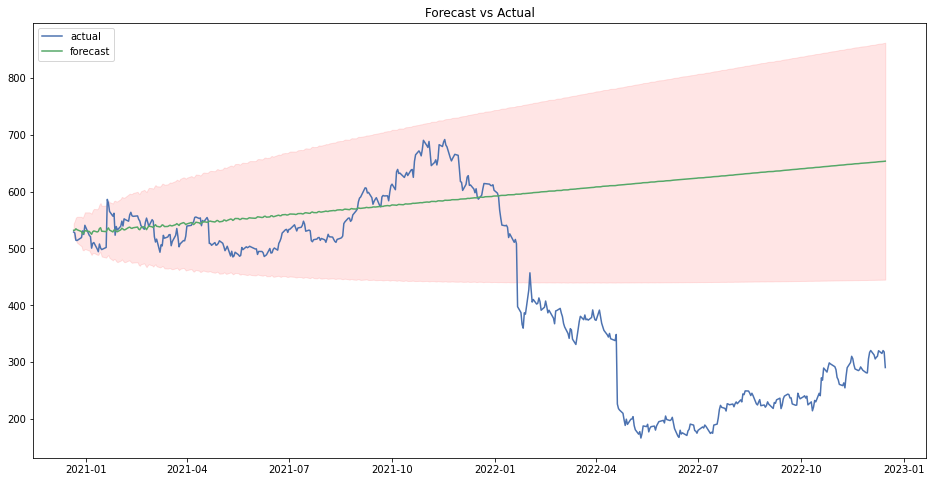

In [262]:
step = 501 #Len of the test
fc , se , conf = result_NFLX.forecast(step)
fc = pd.Series(fc, index = test[ : step].index)
lower = pd.Series(conf[: ,0], index = test[: step].index)
upper = pd.Series(conf[: ,1], index = test[: step].index)
plt.figure(figsize = (16,8))
plt.plot(test[:step], label = "actual")
plt.plot(fc,label = "forecast")
plt.fill_between(lower.index,lower,upper,color="r",alpha = 0.1)
plt.title("Forecast vs Actual")
plt.legend(loc = "upper left")

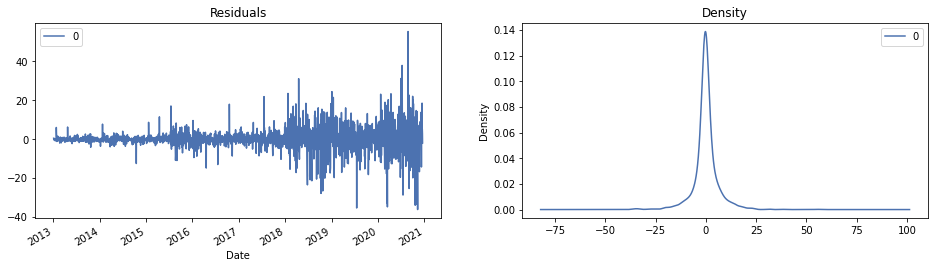

In [263]:
residuals = pd.DataFrame(result_NFLX.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title='Residuals', ax=ax[0], figsize = (16,4))
residuals.plot(title='Density', kind='kde', ax=ax[1])
plt.show();

<Figure size 1152x11520 with 0 Axes>

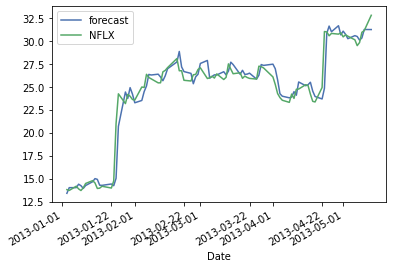

In [264]:
#actual vs fitted 
#figure(figsize=(20, 30), dpi=400)
plt.figure(figsize=(16,160))
result_NFLX.plot_predict(
    start = 1,
    end = 90,
    dynamic= False
);

<Figure size 1152x11520 with 0 Axes>

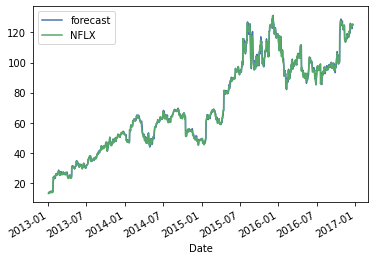

In [265]:
#actual vs fitted 
#figure(figsize=(20, 30), dpi=400)
plt.figure(figsize=(16,160))
result_NFLX.plot_predict(
    start = 1,
    end = 1000,
    dynamic= False
);

In [266]:
step = 1000
fc , se , conf = result_NFLX.forecast(step)

In [267]:
#futAapl = pd.DataFrame(fc)
#futAapl
begin_date = '2022-12-13'
NFLX = pd.DataFrame({'Date':pd.date_range(begin_date, periods=step),
                      "NFLX": fc
                   }).set_index('Date')
'''
temp = df.append(Apple)

temp
'''

'\ntemp = df.append(Apple)\n\ntemp\n'

DF with predictions


In [268]:
#df1.merge(df2,on='name').merge(df3,on='name')
#META	AAPL	NFLX	GOOG	AIG	QCOM
pred = META.merge(Apple, on = "Date").merge(NFLX, on = "Date").merge(GOOG, on = "Date" ).merge(AIG, on = "Date").merge(QCOM, on = "Date")
df2 = df.append(pred)
df2

,META,AAPL,NFLX,GOOG,AIG,QCOM
Date,,,,,,
2013-01-02,28.000000,16.862823,13.144286,18.013729,29.553608,48.689095
2013-01-03,27.770000,16.649982,13.798571,18.024191,29.310566,48.463520
2013-01-04,28.760000,16.186203,13.711429,18.380356,29.407784,47.749161
2013-01-07,29.420000,16.090984,14.171429,18.300158,29.108036,48.132648
2013-01-08,29.059999,16.134295,13.880000,18.264042,28.881207,48.057457
...,...,...,...,...,...,...
2025-09-03,400.026458,179.455165,780.039835,120.832972,38.607960,187.874944
2025-09-04,400.150387,179.509315,780.295565,120.867244,38.611714,187.921292
2025-09-05,400.274316,179.563465,780.551274,120.901516,38.614649,187.967639


<function matplotlib.pyplot.show(*args, **kw)>

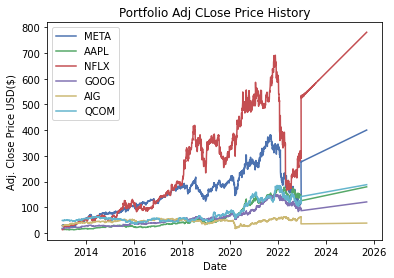

In [269]:
#visualize the path of the portfolio stocks
title = "Portfolio Adj CLose Price History"

# Get the stocks
my_stocks = df2

#Create and plot the graph
for c in my_stocks.columns.values:
  plt.plot(my_stocks[c], label = c)


plt.title(title)
plt.xlabel("Date")
plt.ylabel("Adj. Close Price USD($)")
plt.legend(my_stocks.columns.values, loc = "upper left")
plt.show

Efficient frontier on the forecast data

In [270]:
#Portfolio Optimization

#Calc the exp returns and the anualized smaple covariance matrix of the asset returns
mu = expected_returns.mean_historical_return(df2)
S = risk_models.sample_cov(df2)

#Optimize for max sharpe ratio 
ef = EfficientFrontier(mu,S)

weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()
print(cleaned_weights)
ef.portfolio_performance(verbose = True)


OrderedDict([('META', 0.0), ('AAPL', 0.5738), ('NFLX', 0.33935), ('GOOG', 0.08686), ('AIG', 0.0), ('QCOM', 0.0)])
Expected annual return: 23.5%
Annual volatility: 24.7%
Sharpe Ratio: 0.87


(0.23475835215678026, 0.24678162923715766, 0.87023638194072)

Plot efficient frontier

<Figure size 4800x4000 with 0 Axes>

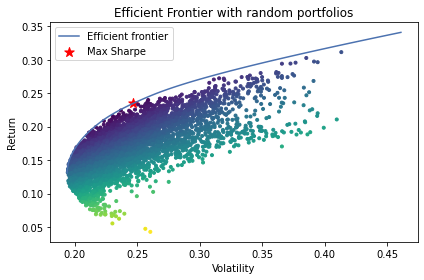

In [277]:
figure(figsize=(12, 10), dpi=400)
ef = EfficientFrontier(mu,S)
fig, ax = plt.subplots()
ef_max_sharpe = ef.deepcopy()
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=False)

# Find the tangency portfolio
ef_max_sharpe.max_sharpe()
ret_tangent, std_tangent, _ = ef_max_sharpe.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Max Sharpe")

# Generate random portfolios
n_samples = 5000
w = np.random.dirichlet(np.ones(ef.n_assets), n_samples)
rets = w.dot(ef.expected_returns)
stds = np.sqrt(np.diag(w @ ef.cov_matrix @ w.T))
sharpes = rets / stds
ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")

# Output
ax.set_title("Efficient Frontier with random portfolios")
ax.legend()
plt.tight_layout()
plt.savefig("ef_scatter.png", dpi=200)
plt.show()

In [279]:
#Get the discrete allocation of each share per stock
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices
latest_prices = get_latest_prices(df)

weights = cleaned_weights

da = DiscreteAllocation(weights, latest_prices, total_portfolio_value= 1000)

allocation2, leftover2 = da.lp_portfolio()
print("discrete Allocairton :", allocation)
print("Fund remaining :" , leftover)

discrete Allocairton : {'AAPL': 44, 'NFLX': 12, 'GOOG': 5}
Fund remaining : 138.74033880510615


Finding the return of the initial portfolio

In [280]:
df.iloc[-1]

META    119.430000
AAPL    134.509995
NFLX    290.709991
GOOG     90.860001
AIG      62.570000
QCOM    114.529999
Name: 2022-12-16 00:00:00, dtype: float64

In [281]:
returns_new = df.pct_change()
returns_new

,META,AAPL,NFLX,GOOG,AIG,QCOM
Date,,,,,,
2013-01-02,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-03,-0.008214,-0.012622,0.049777,0.000581,-0.008224,-0.004633
2013-01-04,0.035650,-0.027855,-0.006315,0.019760,0.003317,-0.014740
2013-01-07,0.022949,-0.005883,0.033549,-0.004363,-0.010193,0.008031
2013-01-08,-0.012237,0.002692,-0.020565,-0.001974,-0.007793,-0.001562
...,...,...,...,...,...,...
2022-12-12,-0.010267,0.016390,-0.015093,0.005265,0.015997,0.018144
2022-12-13,0.047424,0.006782,0.016372,0.024476,0.000787,0.018810
2022-12-14,0.011985,-0.015536,-0.007835,-0.005634,-0.009171,-0.014414


In [284]:
weight_initial = np.array([0.0, 0.60321, 0.35725, 0.03954, 0.0, 0.0])

In [288]:
#Create and show the annualized covariance matrix
cov_matrix_annual = returns_new.cov() * 252

# Create and show the portoflio variance
port_variance_new = np.dot(weight_initial.T, np.dot(cov_matrix_annual, weight_initial))
port_variance_new

0.08249570287041846

In [292]:
portfolioReturn_new = np.sum(returns_new.mean() *weight_initial)*252
portfolioReturn_new

0.3109948070494254

<Figure size 4800x4000 with 0 Axes>

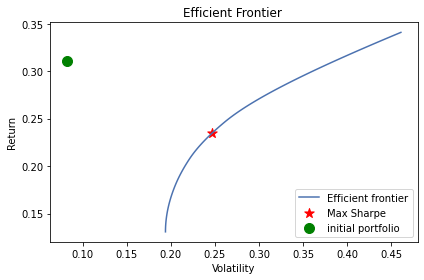

In [303]:
figure(figsize=(12, 10), dpi=400)
ef = EfficientFrontier(mu,S)
fig, ax = plt.subplots()
ef_max_sharpe = ef.deepcopy()
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=False)

# Find the tangency portfolio
ef_max_sharpe.max_sharpe()
ret_tangent, std_tangent, _ = ef_max_sharpe.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Max Sharpe")


# Output
ax.set_title("Efficient Frontier ")
plt.scatter(port_variance_new,portfolioReturn_new, c = "g", s= 100, label = "initial portfolio")
ax.legend()
plt.tight_layout()
plt.savefig("ef_scatter.png", dpi=200)
plt.show()

Comparison

The initial optimal portofolio with max Sharpe ratio seems to have higher performace but it went out of efficient frontier with low diversification and high risk of loosing